<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/WOOK/CCIT_graphcodebert_N_N(%EA%B7%9C%EC%A0%9C_%EB%B0%8F_%EC%98%A4%EB%B2%84_%EC%83%98%ED%94%8C%EB%A7%81)_0605.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cwe file/sliceing_dataset.csv')

In [6]:
df.head(10)

,Unnamed: 0,code_x,lang,CWE ID,vul,code_y
0,0,void CWE415_Double_Free__malloc_free_char_01_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
1,1,void CWE415_Double_Free__malloc_free_char_02_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
2,2,void CWE415_Double_Free__malloc_free_char_03_b...,c,CWE-415,1,data = NULL;\nif(5==5)\ndata = (char *)malloc(...
3,3,void CWE415_Double_Free__malloc_free_char_04_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
4,4,void CWE415_Double_Free__malloc_free_char_05_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
5,5,void CWE415_Double_Free__malloc_free_char_06_b...,c,CWE-415,1,data = NULL;\nif(STATIC_CONST_FIVE==5)\ndata =...
6,6,void CWE415_Double_Free__malloc_free_char_07_b...,c,CWE-415,1,data = NULL;\nif(staticFive==5)\ndata = (char ...
7,7,void CWE415_Double_Free__malloc_free_char_08_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
8,8,void CWE415_Double_Free__malloc_free_char_09_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
9,9,void CWE415_Double_Free__malloc_free_char_10_b...,c,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...


In [7]:
# code_x 컬럼 삭제
df = df.drop(columns=['code_x'])

# code_y 컬럼 이름을 code로 변경
df.rename(columns={'code_y': 'code'}, inplace=True)

# CWE ID에 따른 labels 컬럼 생성
cwe_mapping = {
    'CWE-415': 0,
    'CWE-119': 1,
    'CWE-20': 2,
    'CWE-125': 3,
    'CWE-787': 4,
    'CWE-416': 5,
    'CWE-476': 6,
    'CWE-399': 7,
    'CWE-190': 8
}

df['labels'] = df['CWE ID'].map(cwe_mapping)


In [8]:
df = df.drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['lang'])
df = df.drop(columns = ['vul'])
df = df.drop(columns = ['CWE ID'])

In [9]:
df

,code,labels
0,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
1,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
2,data = NULL;\nif(5==5)\ndata = (char *)malloc(...,0
3,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
4,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
...,...,...
7289,const size_t so_ext_len= sizeof(SO_EXT) - 1;\n...,5
7290,"if (conn->out_size) {\nn=write(conn->hnd.fd, b...",4
7291,struct zlib_state *state = (struct zlib_state ...,7
7292,COMP_METHOD *meth = &zlib_method_nozlib;,7


In [10]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
# 오버샘플링 적용
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df.drop(columns=['labels']), df['labels'])

# 오버샘플링된 데이터를 다시 Dataset 객체로 변환
df = pd.concat([X_res, y_res], axis=1)

In [11]:
# 라벨이 int64 타입인지 확인
df['labels'] = df['labels'].astype(int)

In [12]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [13]:
import pandas as pd
import re
import gensim
import transformers
from gensim.models import Word2Vec
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from datasets import load_dataset
from pandas.core.common import random_state
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import logging
import sklearn.metrics as metric
from transformers import DataCollatorWithPadding
import torch,gc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from transformers import RobertaTokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, RobertaForSequenceClassification

In [14]:
# 데이터 전처리 함수
def preprocess(df):
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "\n", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), " ", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    return df

df = preprocess(df)

# 데이터셋 생성
dataset = Dataset.from_pandas(df)
def tokenized(examples):
    return tokenizer(examples['code'], padding="max_length", max_length=MAX_LEN, truncation=True)


In [15]:
# 토크나이저 및 데이터셋 인코딩
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
MAX_LEN = 512
encoded_dataset = dataset.map(tokenized, batched=True)
encoded_dataset = encoded_dataset.train_test_split(0.3, seed=100)

# 모델 준비
model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=9)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/14922 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, betas=(0.9,0.99), eps=1e-8, weight_decay=0.1)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=5, num_training_steps=5)
optimizers = (optimizer, scheduler)

In [17]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_per_class = f1_score(labels, predictions, average=None, labels=range(9))
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }
    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1
    return metrics

In [19]:
from transformers import TrainerCallback
class CustomTrainerCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, early_stopping_patience=5):
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.incorrect_samples = []

    def on_evaluate(self, args, state, control, **kwargs):
        eval_loss = kwargs.get('metrics', {}).get('eval_loss')
        if eval_loss is not None:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                print(f"No improvement in {self.early_stopping_patience} evaluation steps. Stopping training early.")
                control.should_training_stop = True
        eval_dataloader = self.trainer.get_eval_dataloader(self.eval_dataset)
        self.trainer.model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(self.trainer.args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.trainer.model(**batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = batch['labels']
                incorrect_mask = predictions != labels
            if incorrect_mask.any():
                incorrect_samples = {k: v[incorrect_mask].cpu().numpy() for k, v in batch.items()}
                self.incorrect_samples.append(incorrect_samples)
        print("Collected incorrect predictions for further analysis.")

In [20]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,  # 배치 크기를 줄임
    per_device_eval_batch_size=16,  # 배치 크기를 줄임
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='loss'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)

callback = CustomTrainerCallback(trainer, encoded_dataset['test'], 5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    callbacks=[callback]
)

gc.collect()
torch.cuda.empty_cache()

# 디버깅 정보 출력
print("Training dataset size:", len(encoded_dataset['train']))
print("Validation dataset size:", len(encoded_dataset['test']))

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training dataset size: 10445
Validation dataset size: 4477


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.903500,1.633279,0.409873,0.409873,0.378308,0.372764,0.409873,0.948118,0.056604,0.020243,0.360288,0.345679,0.487265,0.282073,0.439698,0.414903
1000,1.366300,1.112986,0.637257,0.637257,0.639819,0.636692,0.637257,0.951613,0.422717,0.413295,0.665912,0.593505,0.665885,0.610169,0.653538,0.753597
1500,0.889100,0.774707,0.771945,0.771945,0.776595,0.773990,0.771945,0.969518,0.560799,0.736723,0.789700,0.658397,0.807442,0.768386,0.845927,0.829016
2000,0.648100,0.651896,0.809917,0.809917,0.812993,0.810520,0.809917,0.971372,0.600518,0.791932,0.779817,0.745146,0.860174,0.810757,0.883258,0.851703
2500,0.554800,0.675655,0.819522,0.819522,0.823189,0.821591,0.819522,0.969518,0.636123,0.816931,0.811060,0.760736,0.871849,0.864560,0.805071,0.858473
3000,0.408700,0.598468,0.857717,0.857717,0.858982,0.857185,0.857717,0.964981,0.750000,0.812698,0.779102,0.824675,0.898969,0.884861,0.934615,0.864762
3500,0.336100,0.593161,0.868215,0.868215,0.870424,0.868816,0.868215,0.968750,0.724229,0.868798,0.838782,0.828992,0.918164,0.888417,0.921818,0.861395
4000,0.349000,0.572447,0.886084,0.886084,0.887782,0.886152,0.886084,0.972387,0.764151,0.870370,0.866242,0.858696,0.918756,0.861868,0.956772,0.906122
4500,0.245400,0.549692,0.893009,0.893009,0.893909,0.892648,0.893009,0.973451,0.786290,0.900208,0.867238,0.867925,0.930556,0.897872,0.943689,0.866607
5000,0.248100,0.580402,0.883627,0.883627,0.883306,0.882055,0.883627,0.975369,0.803943,0.885512,0.833333,0.862327,0.916501,0.881356,0.937674,0.842478


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predicti

TrainOutput(global_step=13000, training_loss=0.33406218470059906, metrics={'train_runtime': 10202.1599, 'train_samples_per_second': 10.238, 'train_steps_per_second': 1.28, 'total_flos': 2.735816511636173e+16, 'train_loss': 0.33406218470059906, 'epoch': 9.95405819295559})

In [21]:
callback = CustomTrainerCallback(trainer, encoded_dataset['test'], 5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    callbacks=[callback]
)


In [22]:
gc.collect()
torch.cuda.empty_cache()

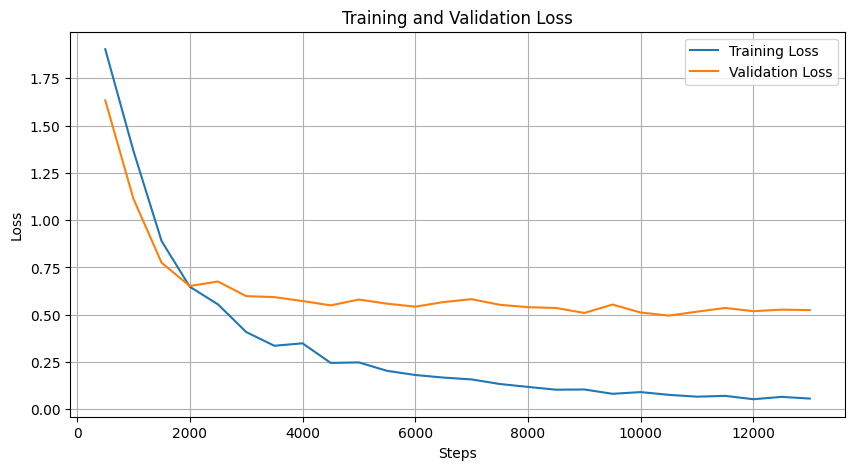

In [27]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')